In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import datetime as dt
import math
import os
from itertools import product
from datetime import datetime
from dateutil.relativedelta import relativedelta
from quant_functions import anal_funcs, data_funcs

import yfinance as yf
## FRED 정보 수집
from fredapi import Fred

In [2]:
# 시각화 관련
import plotly_express as px
import plotly.figure_factory as ff
import cufflinks as cf
cf.go_offline(connected=True)
## cf.getThemes()
cf.set_config_file(theme='polar')
import plotly.graph_objects as go

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')
## plt.style.use("fivethirtyeight")
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = (10,6)

In [3]:
## 그리기 설정값
color_basic = "#3b4a6b" # 네이비 기본색
color_norm = "#f23557" # 진홍색 강조색
color_cont = "#22b2da" # 파란색 대비색
color_sub = "#ff6f3c" # 주황색 보조색
color_around = "#6E6E6E" # 회색 주변색
color_around2 = "#E0E0E0" # 연회색 주변색

figsize=(12, 8)

##### Function #####

In [4]:
def simulate_portfolio_assets(asset_rets_df, weights_list, initial_investment=100):
    """
    n개의 자산에 대한 투자 비중에 따른 포트폴리오 시뮬레이션.

    Parameters:
        asset_returns (list of pd.Series): 각 자산의 수익률 시계열 데이터프레임.
        weights_list (list of list): 자산별 비중 리스트. 각 리스트의 합은 1이어야 함.
        initial_investment (float): 초기 투자 금액 (기본값: 100).

    Returns:
        pd.DataFrame: 각 비중 조합에 대한 포트폴리오 가치 시계열 데이터프레임.
    """
    asset_rets_list = [asset_rets_df[col] for col in asset_rets_df.columns]
    portfolio_values = {}
    for weights in weights_list:
        _weights = [i/sum(weights) for i in weights]
        # 포트폴리오 수익률 계산 (각 자산의 비중 곱)
        portfolio_returns = sum(w * r for w, r in zip(_weights, asset_rets_list))
        # 초기 투자 금액 기준 포트폴리오 가치 시계열 계산
        portfolio_cum_value = initial_investment * (1 + portfolio_returns).cumprod()
        portfolio_values[str(weights)] = portfolio_cum_value

    # 데이터프레임으로 변환
    portfolio_df = pd.DataFrame(portfolio_values)
    return portfolio_df

def split_time_series(df, n_days):
    split_days = n_days
    dfs = []
    for i in range(len(df)-split_days+1):
        dfs.append(df[i:split_days+i])
    return dfs

## beta를 이용한 imputation
def imputation(df, basis_name, target_name):
    dataset = df.copy()
    rets = dataset[[target_name, basis_name]].dropna(subset=[basis_name]).pct_change()
    
    # 공분산과 분산 계산
    cov_matrix = np.cov(rets.dropna()[target_name], rets.dropna()[basis_name])
    cov_stock_market = cov_matrix[0, 1]  # 공분산
    var_market = cov_matrix[1, 1]        # market 분산
    # 베타 계산
    beta = cov_stock_market / var_market
    rets[target_name][rets[target_name].isna()] = rets[basis_name]*beta
    rets = rets.fillna(0)
    df_imputed = (rets+1).cumprod()
    dataset[target_name] = df_imputed[target_name]
    print(beta)
    return dataset

##### Data Load #####

In [404]:
index = ['최저1인', '최저2인', '최저3인', '최저4인', '중위1인', '중위2인', '중위3인', '중위4인', '상위']
need_cash_ls = [134, 221, 283, 344, 224, 368, 471, 573, 1584]
need_cash_df = pd.DataFrame([index, need_cash_ls], index=["index", "need_cashflow_month"]).T
need_cash_df['need_cashflow_annual'] = need_cash_df['need_cashflow_month']*12
need_cash_df['dividend_rate'] = 3.7 * 0.01
## 3.552
## 3.626
## 3.029
## 3.33
## 3.7
need_cash_df['tax_rate'] = 0.154
need_cash_df['need_kapital'] = (need_cash_df['need_cashflow_annual']/(need_cash_df['dividend_rate']*(1-need_cash_df['tax_rate']))).astype(int)

In [405]:
need_cash_df

,index,need_cashflow_month,need_cashflow_annual,dividend_rate,tax_rate,need_kapital
0,최저1인,134,1608,0.037,0.154,51370
1,최저2인,221,2652,0.037,0.154,84723
2,최저3인,283,3396,0.037,0.154,108491
3,최저4인,344,4128,0.037,0.154,131876
4,중위1인,224,2688,0.037,0.154,85873
5,중위2인,368,4416,0.037,0.154,141077
6,중위3인,471,5652,0.037,0.154,180563
7,중위4인,573,6876,0.037,0.154,219666
8,상위,1584,19008,0.037,0.154,607245


In [7]:
ticker_dict = {'QQQ':'Nasdaq100', 'SPY':'S&P500', 'SCHD':'US_Dividend_Equity',
               'SHY':'Short_Term_Treasury', 'TLT':'Long_Term_Treasury',
               'GC=F':'Gold', '^IXIC':'Nasdaq', '^GSPC':'S&P500'}

In [ ]:
fred = Fred(api_key='cfb4f49f5c1a9396f671b8049d992e56')
DGS20 = fred.get_series('DGS20')
DGS10 = fred.get_series('DGS10')
DGS2 = fred.get_series('DGS2')
DTB3 = fred.get_series('DTB3')
DFF = fred.get_series('DFF')

In [96]:
dataset = data_funcs.get_merged_df('QQQ', 'SPY', 'SCHD', 'SHY', 'TLT', 'GC=F', '^IXIC', '^GSPC')
dataset = dataset[ticker_dict.keys()]
## 무위험자산
dataset['CASH'] = range(len(dataset))
dataset['CASH'] = dataset['CASH'].apply(lambda x:((1.025)**(1/252))**x)
dataset = dataset.rename(columns={'GC=F':'GOLD'})
dataset['DGS20'] = DGS20
dataset['DTB3'] = DTB3
dataset[['DGS20', 'DTB3']] = dataset[['DGS20', 'DTB3']].fillna(method='ffill')

[*********************100%%**********************]  8 of 8 completed


In [276]:
## Interpolation
## naq => QQQ 보간
dataset_imputed = imputation(dataset, '^IXIC', 'QQQ')
dataset_imputed = imputation(dataset_imputed, '^GSPC', 'SPY')
dataset_imputed = imputation(dataset_imputed, '^GSPC', 'SCHD')
dataset_imputed = imputation(dataset_imputed, 'DGS20', 'TLT')

dataset_imputed_small = dataset_imputed[['QQQ', 'SPY', 'SCHD', 'TLT', 'GOLD', 'CASH']].dropna()
dataset_imputed = dataset_imputed[['QQQ', 'SPY', 'SCHD', 'TLT', 'CASH']].dropna()

1.0466671975462625
0.9944362406664935
0.8428891739631965
-0.4149375683795448


In [277]:
dataset_short = dataset[['QQQ', 'SPY', 'SCHD', 'TLT', 'GOLD', 'CASH']].dropna()

In [278]:
## 보간 안하고 결측 제거
dataset_short = dataset_short.resample('M').last()
## 보간 버전
dataset_imputed = dataset_imputed.resample('M').last()
## 약간 보간 버전 금포함
dataset_imputed_small = dataset_imputed_small.resample('M').last()

In [320]:
## 보간근거

In [324]:
## corrset = dataset.rename(columns=ticker_dict).pct_change().corr()
## corrsemi = datasemi.rename(columns=ticker_dict).pct_change().corr()

corrset = dataset[['QQQ', '^IXIC', 'SCHD', '^GSPC', 'TLT', 'DGS20', 'SHY', 'DTB3', 'GOLD']].pct_change().corr()

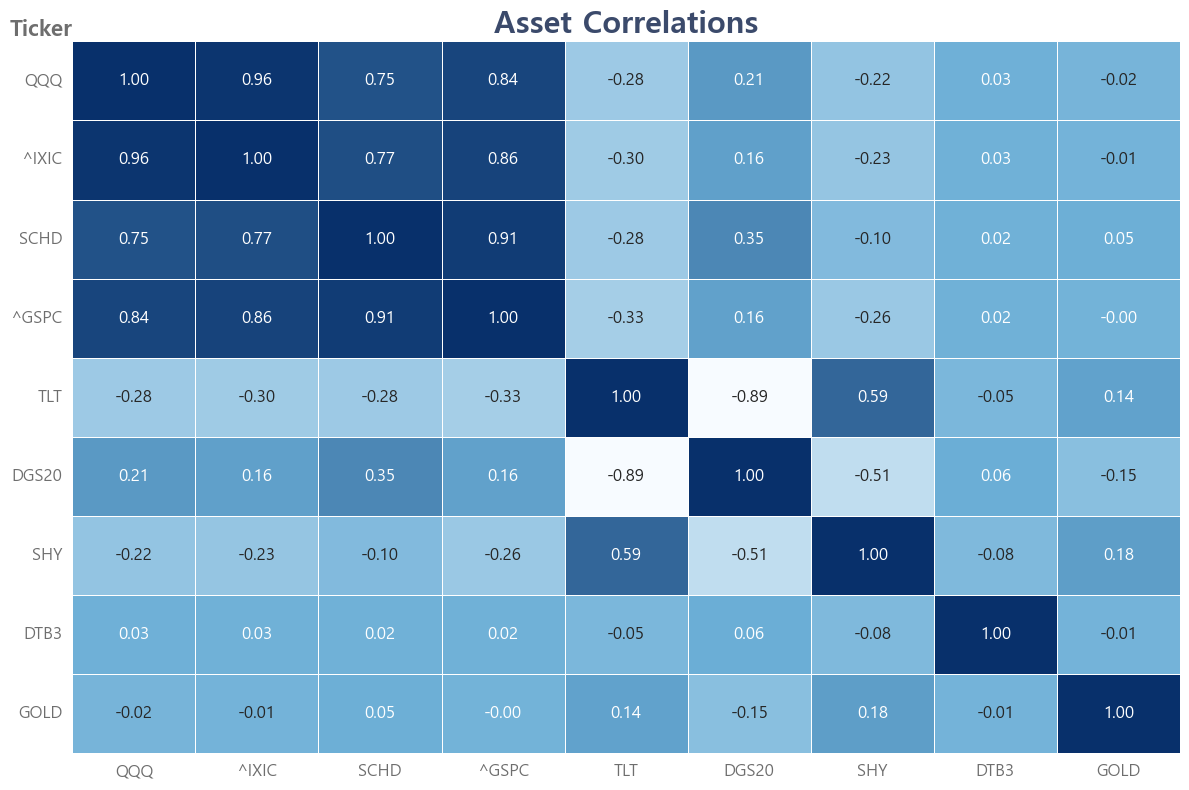

In [327]:
# 히트맵 시각화
plt.figure(figsize=figsize)

custom_colors = ["#F7FBFF", "#6BAED6", "#08306B"]
custom_cmap = LinearSegmentedColormap.from_list("custom", custom_colors)

sns.heatmap(corrset, annot=True, cmap=custom_cmap, fmt='.2f',
            linewidths=0.5, cbar_kws={"shrink": .8}, cbar=False, annot_kws={"size": 12})
plt.title('Asset Correlations', fontsize=22, fontweight="bold", color=color_basic)
plt.ylabel("Ticker", fontsize=16, labelpad=-45, fontweight="bold", color=color_around, loc="top", rotation=0)
plt.xlabel("")
plt.yticks(rotation=0, fontsize=12, color=color_around)
plt.xticks(rotation=0, fontsize=12, color=color_around)
plt.tight_layout()
plt.show()

##### EDA

###### Type0

In [281]:
## 데이터 설정값
ticker_A = 'QQQ'
ticker_B = 'TLT'

In [282]:
df = dataset_imputed_small[[ticker_A, ticker_B]].dropna()
df = df/df.iloc[0]

## data-split
df_ls = split_time_series(df, 5*12)

## calculate Rolling Returns
return_ls = []
ddr_ls = []
_idx = []
for _df in df_ls:
    _df = simulate_portfolio_assets(_df.pct_change().fillna(0), [(10,0), (9, 1), (8, 2), (7, 3), (6, 4), (5, 5), (4, 6), (3, 7), (2, 8), (1, 9), (0,10)])
    _df.columns = [ticker_A, '9:1', '8:2', '7:3', '6:4', '5:5', '4:6', '3:7', '2:8', '1:9', ticker_B]
    return_ls.append([anal_funcs.cal_YRR(_df, col, method ='g', unit = 'monthly') for col in _df.columns])
    ddr_ls.append([anal_funcs.cal_drawdown_risk(_df, col) for col in _df.columns])
    _idx.append(_df.index[0])  
    
return_df_type0_1 = pd.DataFrame(return_ls, columns = _df.columns, index=_idx)
ddr_df_type0_1 = pd.DataFrame(ddr_ls, columns = _df.columns, index=_idx)

sort_df_type0_1 = pd.DataFrame([return_df_type0_1.mean(), ddr_df_type0_1.mean()], index=['Return', 'Volatility']).T

In [283]:
## 데이터 설정값
ticker_A = 'QQQ'
ticker_B = 'GOLD'

In [284]:
df = dataset_imputed_small[[ticker_A, ticker_B]].dropna()
df = df/df.iloc[0]

## data-split
df_ls = split_time_series(df, 5*12)

## calculate Rolling Returns
return_ls = []
ddr_ls = []
_idx = []
for _df in df_ls:
    _df = simulate_portfolio_assets(_df.pct_change().fillna(0), [(10,0), (9, 1), (8, 2), (7, 3), (6, 4), (5, 5), (4, 6), (3, 7), (2, 8), (1, 9), (0,10)])
    _df.columns = [ticker_A, '9:1', '8:2', '7:3', '6:4', '5:5', '4:6', '3:7', '2:8', '1:9', ticker_B]
    return_ls.append([anal_funcs.cal_YRR(_df, col, method ='g', unit = 'monthly') for col in _df.columns])
    ddr_ls.append([anal_funcs.cal_drawdown_risk(_df, col) for col in _df.columns])
    _idx.append(_df.index[0])  
    
return_df_type0_2 = pd.DataFrame(return_ls, columns = _df.columns, index=_idx)
ddr_df_type0_2 = pd.DataFrame(ddr_ls, columns = _df.columns, index=_idx)

sort_df_type0_2 = pd.DataFrame([return_df_type0_2.mean(), ddr_df_type0_2.mean()], index=['Return', 'Volatility']).T

In [285]:
## 데이터 설정값
ticker_A = 'QQQ'
ticker_B = 'SCHD'

In [286]:
df = dataset_imputed_small[[ticker_A, ticker_B]].dropna()
df = df/df.iloc[0]

## data-split
df_ls = split_time_series(df, 5*12)

## calculate Rolling Returns
return_ls = []
ddr_ls = []
_idx = []
for _df in df_ls:
    _df = simulate_portfolio_assets(_df.pct_change().fillna(0), [(10,0), (9, 1), (8, 2), (7, 3), (6, 4), (5, 5), (4, 6), (3, 7), (2, 8), (1, 9), (0,10)])
    _df.columns = [ticker_A, '9:1', '8:2', '7:3', '6:4', '5:5', '4:6', '3:7', '2:8', '1:9', ticker_B]
    return_ls.append([anal_funcs.cal_YRR(_df, col, method ='g', unit = 'monthly') for col in _df.columns])
    ddr_ls.append([anal_funcs.cal_drawdown_risk(_df, col) for col in _df.columns])
    _idx.append(_df.index[0])  
    
return_df_type0_3 = pd.DataFrame(return_ls, columns = _df.columns, index=_idx)
ddr_df_type0_3 = pd.DataFrame(ddr_ls, columns = _df.columns, index=_idx)

sort_df_type0_3 = pd.DataFrame([return_df_type0_3.mean(), ddr_df_type0_3.mean()], index=['Return', 'Volatility']).T

In [287]:
## 데이터 설정값
ticker_A = 'SCHD'
ticker_B = 'TLT'

In [288]:
df = dataset_imputed_small[[ticker_A, ticker_B]].dropna()
df = df/df.iloc[0]

## data-split
df_ls = split_time_series(df, 5*12)

## calculate Rolling Returns
return_ls = []
ddr_ls = []
_idx = []
for _df in df_ls:
    _df = simulate_portfolio_assets(_df.pct_change().fillna(0), [(10,0), (9, 1), (8, 2), (7, 3), (6, 4), (5, 5), (4, 6), (3, 7), (2, 8), (1, 9), (0,10)])
    _df.columns = [ticker_A, '9:1', '8:2', '7:3', '6:4', '5:5', '4:6', '3:7', '2:8', '1:9', ticker_B]
    return_ls.append([anal_funcs.cal_YRR(_df, col, method ='g', unit = 'monthly') for col in _df.columns])
    ddr_ls.append([anal_funcs.cal_drawdown_risk(_df, col) for col in _df.columns])
    _idx.append(_df.index[0])  
    
return_df_type0_4 = pd.DataFrame(return_ls, columns = _df.columns, index=_idx)
ddr_df_type0_4 = pd.DataFrame(ddr_ls, columns = _df.columns, index=_idx)

sort_df_type0_4 = pd.DataFrame([return_df_type0_4.mean(), ddr_df_type0_4.mean()], index=['Return', 'Volatility']).T

In [289]:
## 데이터 설정값
ticker_A = 'SCHD'
ticker_B = 'GOLD'

In [290]:
df = dataset_imputed_small[[ticker_A, ticker_B]].dropna()
df = df/df.iloc[0]

## data-split
df_ls = split_time_series(df, 5*12)

## calculate Rolling Returns
return_ls = []
ddr_ls = []
_idx = []
for _df in df_ls:
    _df = simulate_portfolio_assets(_df.pct_change().fillna(0), [(10,0), (9, 1), (8, 2), (7, 3), (6, 4), (5, 5), (4, 6), (3, 7), (2, 8), (1, 9), (0,10)])
    _df.columns = [ticker_A, '9:1', '8:2', '7:3', '6:4', '5:5', '4:6', '3:7', '2:8', '1:9', ticker_B]
    return_ls.append([anal_funcs.cal_YRR(_df, col, method ='g', unit = 'monthly') for col in _df.columns])
    ddr_ls.append([anal_funcs.cal_drawdown_risk(_df, col) for col in _df.columns])
    _idx.append(_df.index[0])  
    
return_df_type0_5 = pd.DataFrame(return_ls, columns = _df.columns, index=_idx)
ddr_df_type0_5 = pd.DataFrame(ddr_ls, columns = _df.columns, index=_idx)

sort_df_type0_5 = pd.DataFrame([return_df_type0_5.mean(), ddr_df_type0_5.mean()], index=['Return', 'Volatility']).T

###### Type1

In [107]:
## 데이터 설정값
ticker_A = 'QQQ'
ticker_B = 'SCHD'

In [108]:
df = dataset_imputed[[ticker_A, ticker_B]].dropna()
df = df/df.iloc[0]

## data-split
df_ls = split_time_series(df, 5*12)

## calculate Rolling Returns
return_ls = []
ddr_ls = []
_idx = []
for _df in df_ls:
    _df = simulate_portfolio_assets(_df.pct_change().fillna(0), [(10,0), (9, 1), (8, 2), (7, 3), (6, 4), (5, 5), (4, 6), (3, 7), (2, 8), (1, 9), (0,10)])
    _df.columns = [ticker_A, '9:1', '8:2', '7:3', '6:4', '5:5', '4:6', '3:7', '2:8', '1:9', ticker_B]
    return_ls.append([anal_funcs.cal_YRR(_df, col, method ='g', unit = 'monthly') for col in _df.columns])
    ddr_ls.append([anal_funcs.cal_drawdown_risk(_df, col) for col in _df.columns])
    _idx.append(_df.index[0])  
    
return_df_type1 = pd.DataFrame(return_ls, columns = _df.columns, index=_idx)
ddr_df_type1 = pd.DataFrame(ddr_ls, columns = _df.columns, index=_idx)

sort_df_type1 = pd.DataFrame([return_df_type1.mean(), ddr_df_type1.mean()], index=['Return', 'Volatility']).T

###### Type2

In [109]:
## 데이터 설정값
ticker_A = 'QQQ'
ticker_B = 'TLT'

In [110]:
df = dataset_imputed[[ticker_A, ticker_B]].dropna()
df = df/df.iloc[0]

## data-split
df_ls = split_time_series(df, 5*12)

## calculate Rolling Returns
return_ls = []
ddr_ls = []
_idx = []
for _df in df_ls:
    _df = simulate_portfolio_assets(_df.pct_change().fillna(0), [(10,0), (9, 1), (8, 2), (7, 3), (6, 4), (5, 5), (4, 6), (3, 7), (2, 8), (1, 9), (0,10)])
    _df.columns = [ticker_A, '9:1', '8:2', '7:3', '6:4', '5:5', '4:6', '3:7', '2:8', '1:9', ticker_B]
    return_ls.append([anal_funcs.cal_YRR(_df, col, method ='g', unit = 'monthly') for col in _df.columns])
    ddr_ls.append([anal_funcs.cal_drawdown_risk(_df, col) for col in _df.columns])
    _idx.append(_df.index[0])  
    
return_df_type2 = pd.DataFrame(return_ls, columns = _df.columns, index=_idx)
ddr_df_type2 = pd.DataFrame(ddr_ls, columns = _df.columns, index=_idx)

sort_df_type2 = pd.DataFrame([return_df_type2.mean(), ddr_df_type2.mean()], index=['Return', 'Volatility']).T

###### Type3

In [114]:
## 데이터 설정값
ticker_A = 'QQQ'
ticker_B = 'CASH'

In [115]:
df = dataset_imputed[[ticker_A, ticker_B]].dropna()
df = df/df.iloc[0]

## data-split
df_ls = split_time_series(df, 5*12)

## calculate Rolling Returns
return_ls = []
ddr_ls = []
_idx = []
for _df in df_ls:
    _df = simulate_portfolio_assets(_df.pct_change().fillna(0), [(10,0), (9, 1), (8, 2), (7, 3), (6, 4), (5, 5), (4, 6), (3, 7), (2, 8), (1, 9), (0,10)])
    _df.columns = [ticker_A, '9:1', '8:2', '7:3', '6:4', '5:5', '4:6', '3:7', '2:8', '1:9', ticker_B]
    return_ls.append([anal_funcs.cal_YRR(_df, col, method ='g', unit = 'monthly') for col in _df.columns])
    ddr_ls.append([anal_funcs.cal_drawdown_risk(_df, col) for col in _df.columns])
    _idx.append(_df.index[0])  
    
return_df_type3 = pd.DataFrame(return_ls, columns = _df.columns, index=_idx)
ddr_df_type3 = pd.DataFrame(ddr_ls, columns = _df.columns, index=_idx)

sort_df_type3 = pd.DataFrame([return_df_type3.mean(), ddr_df_type3.mean()], index=['Return', 'Volatility']).T

In [167]:
## 현금의 특수성
ddr_df_type3.fillna(0, inplace=True)
sort_df_type3.fillna(0, inplace=True)

###### Type4

In [116]:
## 데이터 설정값
ticker_A = 'SCHD'
ticker_B = 'TLT'

In [117]:
df = dataset_imputed[[ticker_A, ticker_B]].dropna()
df = df/df.iloc[0]

## data-split
df_ls = split_time_series(df, 5*12)

## calculate Rolling Returns
return_ls = []
ddr_ls = []
_idx = []
for _df in df_ls:
    _df = simulate_portfolio_assets(_df.pct_change().fillna(0), [(10,0), (9, 1), (8, 2), (7, 3), (6, 4), (5, 5), (4, 6), (3, 7), (2, 8), (1, 9), (0,10)])
    _df.columns = [ticker_A, '9:1', '8:2', '7:3', '6:4', '5:5', '4:6', '3:7', '2:8', '1:9', ticker_B]
    return_ls.append([anal_funcs.cal_YRR(_df, col, method ='g', unit = 'monthly') for col in _df.columns])
    ddr_ls.append([anal_funcs.cal_drawdown_risk(_df, col) for col in _df.columns])
    _idx.append(_df.index[0])  
    
return_df_type4 = pd.DataFrame(return_ls, columns = _df.columns, index=_idx)
ddr_df_type4 = pd.DataFrame(ddr_ls, columns = _df.columns, index=_idx)

sort_df_type4 = pd.DataFrame([return_df_type4.mean(), ddr_df_type4.mean()], index=['Return', 'Volatility']).T

###### Type5

In [118]:
## 데이터 설정값
ticker_A = 'SCHD'
ticker_B = 'CASH'

In [119]:
df = dataset_imputed[[ticker_A, ticker_B]].dropna()
df = df/df.iloc[0]

## data-split
df_ls = split_time_series(df, 5*12)

## calculate Rolling Returns
return_ls = []
ddr_ls = []
_idx = []
for _df in df_ls:
    _df = simulate_portfolio_assets(_df.pct_change().fillna(0), [(10,0), (9, 1), (8, 2), (7, 3), (6, 4), (5, 5), (4, 6), (3, 7), (2, 8), (1, 9), (0,10)])
    _df.columns = [ticker_A, '9:1', '8:2', '7:3', '6:4', '5:5', '4:6', '3:7', '2:8', '1:9', ticker_B]
    return_ls.append([anal_funcs.cal_YRR(_df, col, method ='g', unit = 'monthly') for col in _df.columns])
    ddr_ls.append([anal_funcs.cal_drawdown_risk(_df, col) for col in _df.columns])
    _idx.append(_df.index[0])  
    
return_df_type5 = pd.DataFrame(return_ls, columns = _df.columns, index=_idx)
ddr_df_type5 = pd.DataFrame(ddr_ls, columns = _df.columns, index=_idx)

sort_df_type5 = pd.DataFrame([return_df_type5.mean(), ddr_df_type5.mean()], index=['Return', 'Volatility']).T

In [ ]:
## 현금의 특수성
ddr_df_type5.fillna(0, inplace=True)
sort_df_type5.fillna(0, inplace=True)

###### Type6

In [179]:
## 데이터 설정값
ticker_A = 'QQQ'
ticker_B = 'SCHD'

In [ ]:
df = dataset_short[[ticker_A, ticker_B]].dropna()
df = df/df.iloc[0]

## data-split
df_ls = split_time_series(df, 5*12)

## calculate Rolling Returns
return_ls = []
ddr_ls = []
_idx = []
for _df in df_ls:
    _df = simulate_portfolio_assets(_df.pct_change().fillna(0), [(10,0), (9, 1), (8, 2), (7, 3), (6, 4), (5, 5), (4, 6), (3, 7), (2, 8), (1, 9), (0,10)])
    _df.columns = [ticker_A, '9:1', '8:2', '7:3', '6:4', '5:5', '4:6', '3:7', '2:8', '1:9', ticker_B]
    return_ls.append([anal_funcs.cal_YRR(_df, col, method ='g', unit = 'monthly') for col in _df.columns])
    ddr_ls.append([anal_funcs.cal_drawdown_risk(_df, col) for col in _df.columns])
    _idx.append(_df.index[0])  
    
return_df_type6 = pd.DataFrame(return_ls, columns = _df.columns, index=_idx)
ddr_df_type6 = pd.DataFrame(ddr_ls, columns = _df.columns, index=_idx)

sort_df_type6 = pd.DataFrame([return_df_type6.mean(), ddr_df_type6.mean()], index=['Return', 'Volatility']).T

###### Type7

In [133]:
## 데이터 설정값
ticker_A = 'QQQ'
ticker_B = 'TLT'

In [134]:
df = dataset_short[[ticker_A, ticker_B]].dropna()
df = df/df.iloc[0]

## data-split
df_ls = split_time_series(df, 5*12)

## calculate Rolling Returns
return_ls = []
ddr_ls = []
_idx = []
for _df in df_ls:
    _df = simulate_portfolio_assets(_df.pct_change().fillna(0), [(10,0), (9, 1), (8, 2), (7, 3), (6, 4), (5, 5), (4, 6), (3, 7), (2, 8), (1, 9), (0,10)])
    _df.columns = [ticker_A, '9:1', '8:2', '7:3', '6:4', '5:5', '4:6', '3:7', '2:8', '1:9', ticker_B]
    return_ls.append([anal_funcs.cal_YRR(_df, col, method ='g', unit = 'monthly') for col in _df.columns])
    ddr_ls.append([anal_funcs.cal_drawdown_risk(_df, col) for col in _df.columns])
    _idx.append(_df.index[0])  
    
return_df_type7 = pd.DataFrame(return_ls, columns = _df.columns, index=_idx)
ddr_df_type7 = pd.DataFrame(ddr_ls, columns = _df.columns, index=_idx)

sort_df_type7 = pd.DataFrame([return_df_type7.mean(), ddr_df_type7.mean()], index=['Return', 'Volatility']).T

###### Type8

In [135]:
## 데이터 설정값
ticker_A = 'QQQ'
ticker_B = 'GOLD'

In [136]:
df = dataset_short[[ticker_A, ticker_B]].dropna()
df = df/df.iloc[0]

## data-split
df_ls = split_time_series(df, 5*12)

## calculate Rolling Returns
return_ls = []
ddr_ls = []
_idx = []
for _df in df_ls:
    _df = simulate_portfolio_assets(_df.pct_change().fillna(0), [(10,0), (9, 1), (8, 2), (7, 3), (6, 4), (5, 5), (4, 6), (3, 7), (2, 8), (1, 9), (0,10)])
    _df.columns = [ticker_A, '9:1', '8:2', '7:3', '6:4', '5:5', '4:6', '3:7', '2:8', '1:9', ticker_B]
    return_ls.append([anal_funcs.cal_YRR(_df, col, method ='g', unit = 'monthly') for col in _df.columns])
    ddr_ls.append([anal_funcs.cal_drawdown_risk(_df, col) for col in _df.columns])
    _idx.append(_df.index[0])  
    
return_df_type8 = pd.DataFrame(return_ls, columns = _df.columns, index=_idx)
ddr_df_type8 = pd.DataFrame(ddr_ls, columns = _df.columns, index=_idx)

sort_df_type8 = pd.DataFrame([return_df_type8.mean(), ddr_df_type8.mean()], index=['Return', 'Volatility']).T

###### Type9

In [137]:
## 데이터 설정값
ticker_A = 'QQQ'
ticker_B = 'CASH'

In [138]:
df = dataset_short[[ticker_A, ticker_B]].dropna()
df = df/df.iloc[0]

## data-split
df_ls = split_time_series(df, 5*12)

## calculate Rolling Returns
return_ls = []
ddr_ls = []
_idx = []
for _df in df_ls:
    _df = simulate_portfolio_assets(_df.pct_change().fillna(0), [(10,0), (9, 1), (8, 2), (7, 3), (6, 4), (5, 5), (4, 6), (3, 7), (2, 8), (1, 9), (0,10)])
    _df.columns = [ticker_A, '9:1', '8:2', '7:3', '6:4', '5:5', '4:6', '3:7', '2:8', '1:9', ticker_B]
    return_ls.append([anal_funcs.cal_YRR(_df, col, method ='g', unit = 'monthly') for col in _df.columns])
    ddr_ls.append([anal_funcs.cal_drawdown_risk(_df, col) for col in _df.columns])
    _idx.append(_df.index[0])  
    
return_df_type9 = pd.DataFrame(return_ls, columns = _df.columns, index=_idx)
ddr_df_type9 = pd.DataFrame(ddr_ls, columns = _df.columns, index=_idx)

sort_df_type9 = pd.DataFrame([return_df_type9.mean(), ddr_df_type9.mean()], index=['Return', 'Volatility']).T

In [146]:
## 현금의 특수성
ddr_df_type9.fillna(0, inplace=True)
sort_df_type9.fillna(0, inplace=True)

###### Type10

In [140]:
## 데이터 설정값
ticker_A = 'SCHD'
ticker_B = 'TLT'

In [141]:
df = dataset_short[[ticker_A, ticker_B]].dropna()
df = df/df.iloc[0]

## data-split
df_ls = split_time_series(df, 5*12)

## calculate Rolling Returns
return_ls = []
ddr_ls = []
_idx = []
for _df in df_ls:
    _df = simulate_portfolio_assets(_df.pct_change().fillna(0), [(10,0), (9, 1), (8, 2), (7, 3), (6, 4), (5, 5), (4, 6), (3, 7), (2, 8), (1, 9), (0,10)])
    _df.columns = [ticker_A, '9:1', '8:2', '7:3', '6:4', '5:5', '4:6', '3:7', '2:8', '1:9', ticker_B]
    return_ls.append([anal_funcs.cal_YRR(_df, col, method ='g', unit = 'monthly') for col in _df.columns])
    ddr_ls.append([anal_funcs.cal_drawdown_risk(_df, col) for col in _df.columns])
    _idx.append(_df.index[0])  
    
return_df_type10 = pd.DataFrame(return_ls, columns = _df.columns, index=_idx)
ddr_df_type10 = pd.DataFrame(ddr_ls, columns = _df.columns, index=_idx)

sort_df_type10 = pd.DataFrame([return_df_type10.mean(), ddr_df_type10.mean()], index=['Return', 'Volatility']).T

###### Type11

In [142]:
## 데이터 설정값
ticker_A = 'SCHD'
ticker_B = 'GOLD'

In [143]:
df = dataset_short[[ticker_A, ticker_B]].dropna()
df = df/df.iloc[0]

## data-split
df_ls = split_time_series(df, 5*12)

## calculate Rolling Returns
return_ls = []
ddr_ls = []
_idx = []
for _df in df_ls:
    _df = simulate_portfolio_assets(_df.pct_change().fillna(0), [(10,0), (9, 1), (8, 2), (7, 3), (6, 4), (5, 5), (4, 6), (3, 7), (2, 8), (1, 9), (0,10)])
    _df.columns = [ticker_A, '9:1', '8:2', '7:3', '6:4', '5:5', '4:6', '3:7', '2:8', '1:9', ticker_B]
    return_ls.append([anal_funcs.cal_YRR(_df, col, method ='g', unit = 'monthly') for col in _df.columns])
    ddr_ls.append([anal_funcs.cal_drawdown_risk(_df, col) for col in _df.columns])
    _idx.append(_df.index[0])  
    
return_df_type11 = pd.DataFrame(return_ls, columns = _df.columns, index=_idx)
ddr_df_type11 = pd.DataFrame(ddr_ls, columns = _df.columns, index=_idx)

sort_df_type11 = pd.DataFrame([return_df_type11.mean(), ddr_df_type11.mean()], index=['Return', 'Volatility']).T

###### Type12

In [144]:
## 데이터 설정값
ticker_A = 'SCHD'
ticker_B = 'CASH'

In [145]:
df = dataset_short[[ticker_A, ticker_B]].dropna()
df = df/df.iloc[0]

## data-split
df_ls = split_time_series(df, 5*12)

## calculate Rolling Returns
return_ls = []
ddr_ls = []
_idx = []
for _df in df_ls:
    _df = simulate_portfolio_assets(_df.pct_change().fillna(0), [(10,0), (9, 1), (8, 2), (7, 3), (6, 4), (5, 5), (4, 6), (3, 7), (2, 8), (1, 9), (0,10)])
    _df.columns = [ticker_A, '9:1', '8:2', '7:3', '6:4', '5:5', '4:6', '3:7', '2:8', '1:9', ticker_B]
    return_ls.append([anal_funcs.cal_YRR(_df, col, method ='g', unit = 'monthly') for col in _df.columns])
    ddr_ls.append([anal_funcs.cal_drawdown_risk(_df, col) for col in _df.columns])
    _idx.append(_df.index[0])  
    
return_df_type12 = pd.DataFrame(return_ls, columns = _df.columns, index=_idx)
ddr_df_type12 = pd.DataFrame(ddr_ls, columns = _df.columns, index=_idx)

sort_df_type12 = pd.DataFrame([return_df_type12.mean(), ddr_df_type12.mean()], index=['Return', 'Volatility']).T

In [149]:
## 현금의 특수성
ddr_df_type12.fillna(0, inplace=True)
sort_df_type12.fillna(0, inplace=True)

###### 시각화

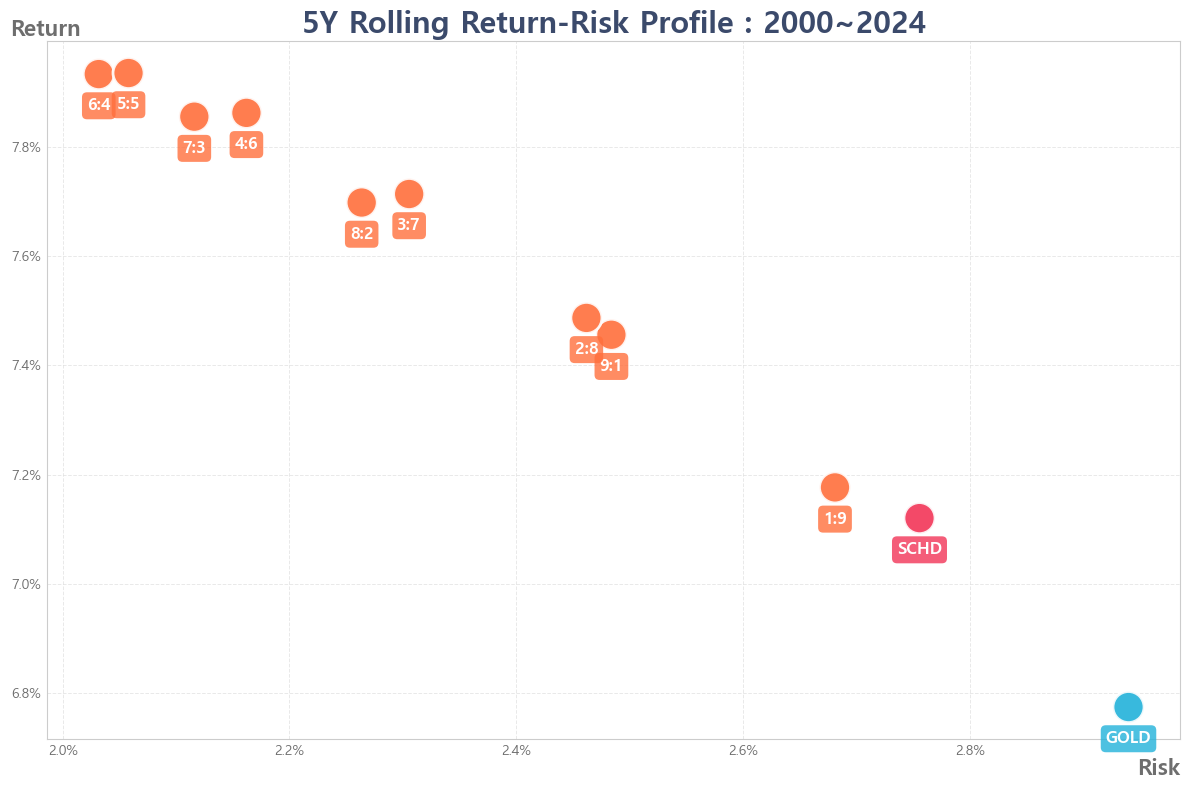

In [299]:
plot_df = sort_df_type0_5.copy()

# 색상 및 크기 설정
colors = [color_norm, color_sub, color_sub, color_sub, color_sub, color_sub, color_sub, color_sub, color_sub, color_sub, color_cont]
sizes = 500

# 그래프 설정
fig, ax = plt.subplots(figsize=figsize)

# 점 그리기
x = plot_df['Volatility']
y = plot_df['Return']
scatter = ax.scatter(x, y, c=colors, s=sizes, edgecolors="white", linewidth=2, alpha=0.9)


# 데이터 레이블 추가
labels = list(plot_df.index)
for i, label in enumerate(labels):
    plt.text(
        x[i], y[i]-np.abs(y.max()-y.min())*0.05, label, fontsize=12, ha="center", va="center", 
        color="white", fontweight="bold", bbox=dict(facecolor=colors[i], edgecolor='none', alpha=0.8, boxstyle="round,pad=0.3")
    )

# % 단위를 추가하는 포맷터 함수 정의
def percent_formatter(x, pos):
    return f"{round(x, 2)}%"

# X축, Y축에 % 포맷터 적용
plt.gca().xaxis.set_major_formatter(FuncFormatter(percent_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))
# 눈금과 축 간격 줄이기
plt.gca().tick_params(axis="x", pad=1)  # X축 눈금 패딩 조정
plt.gca().tick_params(axis="y", pad=1)  # Y축 눈금 패딩 조정

# 축 설정
plt.title(f"5Y Rolling Return-Risk Profile : {dataset_imputed_small.index[0].year}~{dataset_imputed_small.index[-1].year}", fontsize=22, fontweight="bold", color=color_basic)
plt.xlabel("Risk", fontsize=16, labelpad=0, fontweight="bold", color=color_around, loc="right")
plt.ylabel("Return", fontsize=16, labelpad=-50, fontweight="bold", color=color_around, loc="top", rotation=0)
plt.xticks(fontsize=10, color=color_around)
plt.yticks(fontsize=10, color=color_around)
# plt.xlim(2.9, 5.7)
# plt.ylim(2.4, 6.9)
plt.grid(color=color_around2, linestyle="--", linewidth=0.7, alpha=0.7)

# 저장 및 출력
plt.tight_layout()
plt.show()

###### 전체 결합

In [300]:
sort_df_type0_1['sortino_ratio'] = (sort_df_type0_1['Return'])/sort_df_type0_1['Volatility']
sort_df_type0_2['sortino_ratio'] = (sort_df_type0_2['Return'])/sort_df_type0_2['Volatility']
sort_df_type0_3['sortino_ratio'] = (sort_df_type0_3['Return'])/sort_df_type0_3['Volatility']
sort_df_type0_4['sortino_ratio'] = (sort_df_type0_4['Return'])/sort_df_type0_4['Volatility']
sort_df_type0_5['sortino_ratio'] = (sort_df_type0_5['Return'])/sort_df_type0_5['Volatility']

sort_df_type1['sortino_ratio'] = (sort_df_type1['Return'])/sort_df_type1['Volatility']
sort_df_type2['sortino_ratio'] = (sort_df_type2['Return'])/sort_df_type2['Volatility']
sort_df_type3['sortino_ratio'] = (sort_df_type3['Return'])/sort_df_type3['Volatility']
sort_df_type4['sortino_ratio'] = (sort_df_type4['Return'])/sort_df_type4['Volatility']
sort_df_type5['sortino_ratio'] = (sort_df_type5['Return'])/sort_df_type5['Volatility']
sort_df_type6['sortino_ratio'] = (sort_df_type6['Return'])/sort_df_type6['Volatility']
sort_df_type7['sortino_ratio'] = (sort_df_type7['Return'])/sort_df_type7['Volatility']
sort_df_type8['sortino_ratio'] = (sort_df_type8['Return'])/sort_df_type8['Volatility']
sort_df_type9['sortino_ratio'] = (sort_df_type9['Return'])/sort_df_type9['Volatility']
sort_df_type10['sortino_ratio'] = (sort_df_type10['Return'])/sort_df_type10['Volatility']
sort_df_type11['sortino_ratio'] = (sort_df_type11['Return'])/sort_df_type11['Volatility']
sort_df_type12['sortino_ratio'] = (sort_df_type12['Return'])/sort_df_type12['Volatility']

In [381]:
_ls = []
for i in [1, 2, 3, 4, 5]:
    temp = globals()['sort_df_type0_{}'.format(i)][globals()['sort_df_type0_{}'.format(i)]['sortino_ratio'] == globals()['sort_df_type0_{}'.format(i)]['sortino_ratio'].max()].reset_index().rename(columns={'index':'portfolio'})
    temp['Ticker_A'] = globals()['sort_df_type0_{}'.format(i)].index[0]
    temp['Ticker_B'] = globals()['sort_df_type0_{}'.format(i)].index[-1]
    temp= temp[['Ticker_A', 'Ticker_B', 'portfolio', 'Return', 'Volatility', 'sortino_ratio']]
    _ls.append(temp)
mid_term_score = pd.concat(_ls)

In [382]:
_ls = []
for i in [7, 8, 6, 10, 11]:
    temp = globals()['sort_df_type{}'.format(i)][globals()['sort_df_type{}'.format(i)]['sortino_ratio'] == globals()['sort_df_type{}'.format(i)]['sortino_ratio'].max()].reset_index().rename(columns={'index':'portfolio'})
    temp['Ticker_A'] = globals()['sort_df_type{}'.format(i)].index[0]
    temp['Ticker_B'] = globals()['sort_df_type{}'.format(i)].index[-1]
    temp= temp[['Ticker_A', 'Ticker_B', 'portfolio', 'Return', 'Volatility', 'sortino_ratio']]
    _ls.append(temp)
short_term_score = pd.concat(_ls)

In [383]:
_ls = []
for i in [2, 1, 4]:
    temp = globals()['sort_df_type{}'.format(i)][globals()['sort_df_type{}'.format(i)]['sortino_ratio'] == globals()['sort_df_type{}'.format(i)]['sortino_ratio'].max()].reset_index().rename(columns={'index':'portfolio'})
    temp['Ticker_A'] = globals()['sort_df_type{}'.format(i)].index[0]
    temp['Ticker_B'] = globals()['sort_df_type{}'.format(i)].index[-1]
    temp= temp[['Ticker_A', 'Ticker_B', 'portfolio', 'Return', 'Volatility', 'sortino_ratio']]
    _ls.append(temp)
long_term_score = pd.concat(_ls)

In [384]:
short_term_score=short_term_score.reset_index(drop=True)

In [385]:
mid_term_score=mid_term_score.reset_index(drop=True)

In [386]:
long_term_score=long_term_score.reset_index(drop=True)
long_term_score['portfolio']= long_term_score['portfolio'].apply(lambda x: x.replace('SCHD', '0:10'))

###### 합산 배당률

In [387]:
div_dict = {"QQQ":0.60, "TLT":4.07, "SCHD":3.33, "GOLD":0}

In [388]:
def _func(df):
    _ls = []
    for i in range(len(df)):
        _div = div_dict[df['Ticker_A'][i]]*int(df['portfolio'][i].split(':')[0])*.1 + div_dict[df['Ticker_B'][i]]*int(df['portfolio'][i].split(':')[1])*.1
        _ls.append(_div)
    return _ls

In [389]:
short_term_score['Dividend'] = _func(short_term_score)
mid_term_score['Dividend'] = _func(mid_term_score)
long_term_score['Dividend'] = _func(long_term_score)

In [390]:
short_term_score

,Ticker_A,Ticker_B,portfolio,Return,Volatility,sortino_ratio,Dividend
0,QQQ,TLT,7:3,10.618080,2.107055,5.039299,1.641
1,QQQ,GOLD,5:5,9.193910,1.529059,6.012790,0.300
2,QQQ,SCHD,7:3,12.741849,2.689022,4.738469,1.419
3,SCHD,TLT,7:3,9.357083,1.754764,5.332389,3.552
4,SCHD,GOLD,6:4,8.956260,1.460531,6.132193,1.998


In [391]:
mid_term_score

,Ticker_A,Ticker_B,portfolio,Return,Volatility,sortino_ratio,Dividend
0,QQQ,TLT,5:5,7.761058,1.967712,3.944205,2.335
1,QQQ,GOLD,5:5,9.133792,2.365410,3.861400,0.300
2,QQQ,SCHD,3:7,7.898674,2.898083,2.725483,2.511
3,SCHD,TLT,6:4,6.700244,1.760497,3.805882,3.626
4,SCHD,GOLD,6:4,7.933510,2.031831,3.904611,1.998


In [392]:
long_term_score

,Ticker_A,Ticker_B,portfolio,Return,Volatility,sortino_ratio,Dividend
0,QQQ,TLT,3:7,4.684254,1.667413,2.809294,3.029
1,QQQ,SCHD,0:10,6.328627,2.679400,2.361957,3.330
2,SCHD,TLT,5:5,4.621870,1.525971,3.028806,3.700
